#Anomaly Detection for Credit Card Fraud Detection
Mannal Kamble - mk8475@nyu.edu \\
Karthvik Sarvade - ks6807@nyu.edu \\
Ajay Kumar Nagilla - na3370@nyu.edu

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset Preparation
Preparing the dataset for the credit card fraud detection model. It includes loading, splitting, and formatting the data for further processing and analysis.


In [11]:
import csv
import torch
from torch.utils.data.dataset import Dataset

# Set a manual seed for reproducibility of results
torch.manual_seed(0)

#A custom dataset class to handle the splitting of credit card data into fraud and non-fraud datasets.
class SplitedDataSet(Dataset):

    def __init__(self, mode="non-fraud"):

        CREDIT_CARD_DIRECTORY = '/content/drive/MyDrive/project/creditcard.csv'

        # Load the data from the CSV file
        self.features = []
        self.labels = []
        csvCreditCard = open(CREDIT_CARD_DIRECTORY)
        CreditCardData = csv.reader(csvCreditCard)

        # Define the class to be skipped based on the mode
        if mode == 'non-fraud':
            skipped_class = '1'  # Skip fraudulent transactions
        elif mode == 'fraud':
            skipped_class = '0'  # Skip non-fraudulent transactions

        # Loop through the data and filter based on the mode
        for row in CreditCardData:
            if row[-1] == skipped_class or row[-1] == 'Class':
                continue
            self.features.append(row[:-1])  # Add feature data
            self.labels.append(row[-1])     # Add label data

        # Convert feature and label data from strings to floats
        for i in range(len(self.features)):
            self.features[i] = list(map(float, self.features[i]))
        self.labels = list(map(float, self.labels))

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)


# Aggregated Dataset
Used for aggregating multiple datasets into a single dataset. It is designed to combine various subsets of data, into a unified format for model training and evaluation in credit card fraud detection.


In [12]:
import torch
from torch.utils.data.dataset import Dataset

class DataSet(Dataset):

    def __init__(self, datasets=[]):

        self.features = []  # Initialize an empty list for features
        self.labels = []    # Initialize an empty list for labels

        # Iterate over each dataset and append its features and labels
        for dataset in datasets:
            # Extract features (excluding the first and last elements) and labels from each dataset
            self.features += [dataset[i][0][1:-1] for i in range(len(dataset))]
            self.labels += [dataset[i][1] for i in range(len(dataset))]

        # Convert the lists of features and labels to torch FloatTensors for processing
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.FloatTensor(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        # Check to ensure that the number of features matches the number of labels
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)


# Dataset Splitting and Preparation
Used for creating and splitting datasets into training and testing sets for the model. This process involves separating the data into non-fraudulent and fraudulent transactions, and then randomly dividing them into subsets for model training and evaluation.


In [13]:
import torch
from torch.utils.data import random_split
import csv
import random

# Set manual seeds for reproducibility of results
torch.manual_seed(4)
random.seed(0)

def getDatasets():

    # Load non-fraudulent and fraudulent data
    non_fraud_Data = SplitedDataSet(mode='non-fraud')
    fraud_Data = SplitedDataSet(mode='fraud')

    # Determine the number of data points for training and testing
    data_point_num = len(non_fraud_Data)
    test_data_point_num = 490  # Number of data points to take out of non fraud data to mix in test dataset
    train_data_point_num = data_point_num - test_data_point_num  # Remaining data points for training

    # Split non-fraudulent data into training and testing subsets
    trainData, nonFraudTestData = random_split(non_fraud_Data, [train_data_point_num, test_data_point_num])

    # Aggregate the training data
    trainData = DataSet([trainData])

    # Split the fraudulent data, taking only 490 data points
    fraud_Data, _ = random_split(fraud_Data, [490, 2])  # Adds upto 492 as there are 492 fraudulant data points

    # Aggregate the testing data (both non-fraudulent and fraudulent)
    testData = DataSet([nonFraudTestData, fraud_Data])

    return trainData, testData


# Neural Network Architecture
Creation of the neural network models used in the credit card fraud detection system. It includes defining and initializing the models for both the discriminator (FCNN) and generator (autoencoder) components of the system.


In [14]:
import torch
import torch.nn as nn

# Function for initializing weights in a normal distribution
def weights_init_normal(m):
    classname = m.__class__.__name__
    # Initialize weights for Convolutional layers
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    # Initialize weights for Linear layers
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)
    # Initialize weights for BatchNorm1d layers
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

# Function to apply weight initialization to the network
def init_weights(net_layer):

    try:
        net_layer.apply(weights_init_normal)
    except:
        raise NotImplementedError('weights initialization error')

# Fully Connected Neural Network (Discriminator)
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        # Define the layers of the FCNN
        self.layer = nn.Sequential(nn.Linear(28, 10),
                                   nn.BatchNorm1d(10),
                                   nn.ReLU(True),
                                   nn.Linear(10, 1))
        # Initialize weights for the layers
        init_weights(self.layer)

    def forward(self, x):
        x = self.layer(x)
        return x

# Autoencoder (Generator)
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(nn.Linear(28, 15),
                                     nn.BatchNorm1d(15),
                                     nn.ReLU(True),
                                     nn.Linear(15, 8),
                                     nn.BatchNorm1d(8),
                                     nn.ReLU(True))
        # Initialize weights for the encoder
        init_weights(self.encoder)

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(nn.Linear(8, 15),
                                     nn.BatchNorm1d(15),
                                     nn.ReLU(True),
                                     nn.Linear(15, 28))
        # Initialize weights for the decoder
        init_weights(self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Performance Evaluation Metrics and Visualization
Evaluating the performance. It includes functions to calculate various performance metrics like accuracy, recall, precision, F1 score, and Matthews Correlation Coefficient (MCC). Additionally, it provides a function to plot and save the Receiver Operating Characteristic (ROC) curve along with the Area Under the Curve (AUC) for visual analysis.


In [15]:
import torch
import matplotlib.pyplot as plt

# Function to plot and save the ROC curve along with AUC
def plot_and_save_fig(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label='AUC = %0.4f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ion()
    plt.savefig('./fig/AUROC')
    plt.pause(2)
    plt.close()

# Function to calculate the Matthews Correlation Coefficient
def get_MCC(TP, FP, FN, TN):
    try:
        MCC = ( TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** (1/2)
        MCC = round(MCC, 4)
    except:
        MCC = 0 # Set MCC to 0 in case of a division by zero
    return MCC

# Function to calculate accuracy
def get_accuracy(TP, FP, FN, TN):
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    accuracy = round(accuracy, 4)
    return accuracy

# Function to calculate recall
def get_recall(TP, FP, FN, TN):
    try:
        recall = TP / (TP + FN)
        recall = round(recall, 4)
    except:
        recall = 'N/A' # Return 'N/A' in case of a division by zero
    return recall

# Function to calculate precision
def get_precision(TP, FP, FN, TN):
    try:
        precision = TP / (TP + FP)
        precision = round(precision, 4)
    except:
        precision = 'N/A'  # Return 'N/A' in case of a division by zero
    return precision

# Function to calculate F1 score
def get_F1_score(TP, FP, FN, TN):
    try:
        recall = get_recall(TP = TP, FP = FP, FN = FN, TN = TN)
        precision = get_precision(TP = TP, FP = FP, FN = FN, TN = TN)
        F1_score = 2 / ((1 / recall) + (1 / precision))
        F1_score = round(F1_score, 4)
    except:
        F1_score = 'N/A'  # Return 'N/A' in case of a division by zero
    return F1_score


# Model Training and Evaluation Setup
Configuring and initiating the training process. It involves setting up training parameters, data loaders, and model architecture, as well as defining the loss functions and optimizers necessary for training the autoencoder (generator) and the fully connected neural network (discriminator).


In [16]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import random

# Setting training parameters
batch_size = 4096
lr = 2e-4  # Learning rate
n_epochs = 1
normalization = 'z_score'
reconstructionLoss = 'SmoothL1'
mode = 'train'


print(f"Parameters: batch_size={batch_size}, lr={lr}, n_epochs={n_epochs}, normalization={normalization}, reconstructionLoss={reconstructionLoss}, mode={mode}")

# Seed setting for reproducibility
#torch.manual_seed(4)
random.seed(0)

# Loading datasets
print(f'Loading the {mode} dataset...')
trainData, testData = getDatasets()

# Creating data loaders for training and testing
trainDataLoader = DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testData, batch_size=batch_size, shuffle=True)
print('Datasets loading finished!')

# Initializing model architectures
print('Building new models...')
generator = autoencoder()  # Generator model (Autoencoder)
discriminator = FCNN()  # Discriminator model (Fully Connected Neural Network)



# Defining optimizers for generator and discriminator
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)
current_epoch = 0

# Setting models to training mode
generator.train()
discriminator.train()

# Setting the reconstruction loss function
reconstructionLoss = nn.SmoothL1Loss()

# Setting adversarial loss functions
BCELoss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
MSELoss = nn.MSELoss()  # Mean Squared Error Loss

# Initializing loss values and confusion matrix elements
g_loss_Re = 0  # Generator reconstruction loss
g_loss_BCE = 0  # Generator Binary Cross-Entropy loss
d_loss_sum = 0  # Discriminator loss sum
TP, FP, FN, TN = 0, 0, 0, 0  # Elements of the confusion matrix for MCC calculation

sig = nn.Sigmoid()  # Sigmoid activation function


Parameters: batch_size=4096, lr=0.0002, n_epochs=1, normalization=z_score, reconstructionLoss=SmoothL1, mode=train
Loading the train dataset...
Datasets loading finished!
Building new models...


# Training Loop
This section details the training loop for the model. It outlines the process for each epoch, including training the generator (autoencoder) and discriminator (FCNN), updating weights, calculating loss


In [17]:
print('start running on train mode...')
for epoch in range(current_epoch, n_epochs):
    print('epoch:', epoch + 1)
    # Resetting loss accumulators for each epoch
    g_loss_Re = 0  # Generator reconstruction loss
    g_loss_BCE = 0 # Generator Binary Cross-Entropy loss
    d_loss_sum = 0 # Discriminator loss sum

    # Iterating over the training dataset
    for i, (features, labels) in enumerate(trainDataLoader):
        labels = labels.unsqueeze(1)  # Adjusting the shape of labels

        # Exception handling to stop training if labels contain any non-zero (fraudulent) data
        if torch.sum(labels) != 0:
            raise Exception('stop')

        # Creating real and fake labels for training
        real_label = torch.ones(labels.size())
        fake_label = torch.zeros(labels.size())

        # Train Generator
        # Generating the reconstruction
        reconstruction = generator(features)
        # Calculating reconstruction loss
        Re_Loss = reconstructionLoss(reconstruction, features)
        # Getting discriminator's prediction on the fake data
        fake_pred = discriminator(reconstruction)
        # Calculating Binary Cross-Entropy loss
        BCE_Loss = BCELoss(fake_pred, real_label)
        # Total generator loss
        g_loss = Re_Loss + BCE_Loss

        # Zeroing out previous gradients
        g_optimizer.zero_grad()
        # Backpropagation
        g_loss.backward()
        # Update generator weights
        g_optimizer.step()

        # Accumulating the losses
        g_loss_Re += torch.sum(Re_Loss)
        g_loss_BCE += torch.sum(Re_Loss)

        # Train Discriminator
        # Getting discriminator's prediction on real data
        real_pred = discriminator(features)
        # Calculating loss on real data
        real_loss = BCELoss(real_pred, real_label)

        # Getting discriminator's prediction on fake data (detached)
        fake_pred = discriminator(reconstruction.detach())
        # Calculating loss on fake data
        fake_loss = BCELoss(fake_pred, fake_label)

        # Total discriminator loss
        d_loss = real_loss + fake_loss

        # Zeroing out previous gradients
        d_optimizer.zero_grad()
        # Backpropagation
        d_loss.backward()
        # Update discriminator weights
        d_optimizer.step()

        # Accumulating the discriminator loss
        d_loss_sum += torch.sum(d_loss)

        # Logging the losses every 10 iterations
        if (i + 1) % 10 == 0:
            print("iteration: {} / {}, Epoch: {} / {}, g_loss_Re: {:.5f}, g_loss_BCE: {:.4f}, d_loss: {:.4f}".format(
                str((i+1)*batch_size), len(trainData), epoch+1, n_epochs, g_loss_Re.data / (500*batch_size), g_loss_BCE.data / (500*batch_size), d_loss_sum.data / (500*batch_size)))
            g_loss_Re = 0
            g_loss_BCE = 0
            d_loss_sum = 0


start running on train mode...
epoch: 1
iteration: 40960 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 81920 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 122880 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 163840 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 204800 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 245760 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000


# Testing and Performance Evaluation
This section of the notebook focuses on evaluating the trained credit card fraud detection model. It includes running the model in test mode, setting various thresholds for fraud detection, calculating confusion matrix elements (TP, FP, TN, FN), and computing key performance metrics like ROC-AUC, accuracy, recall, precision, F1 score, and MCC.


start running on test mode...
threshold: 0.05
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


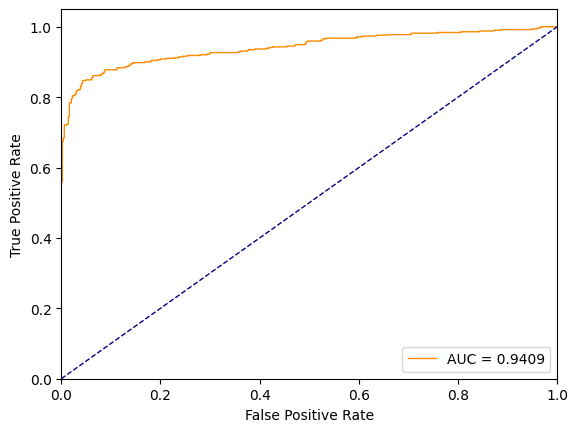

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.1
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


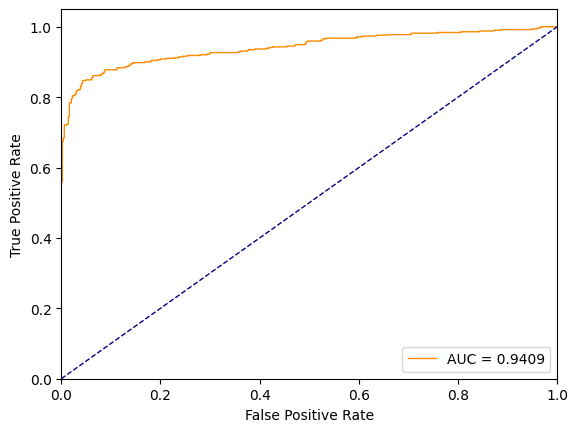

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.15
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


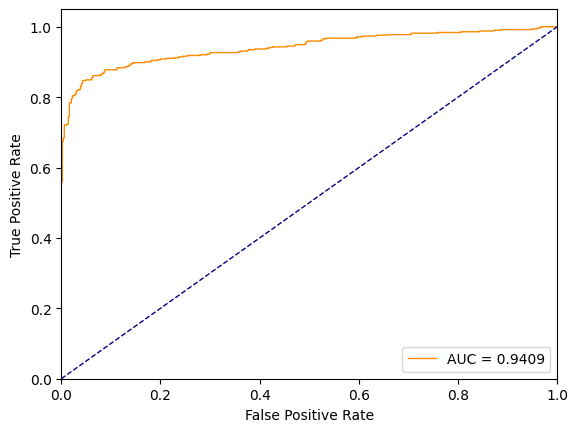

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.2
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


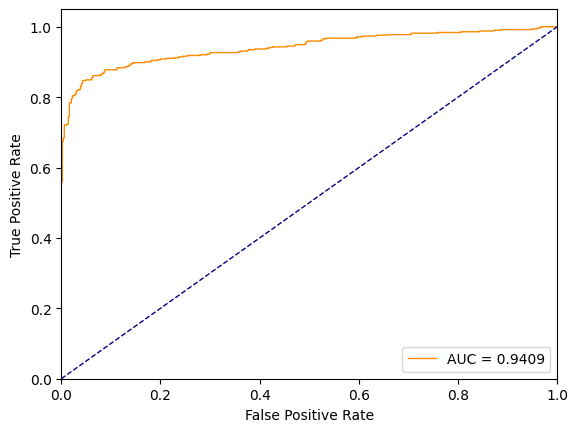

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.25
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


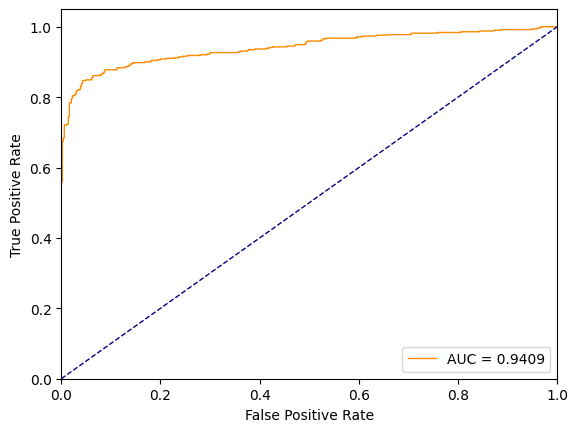

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.3
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


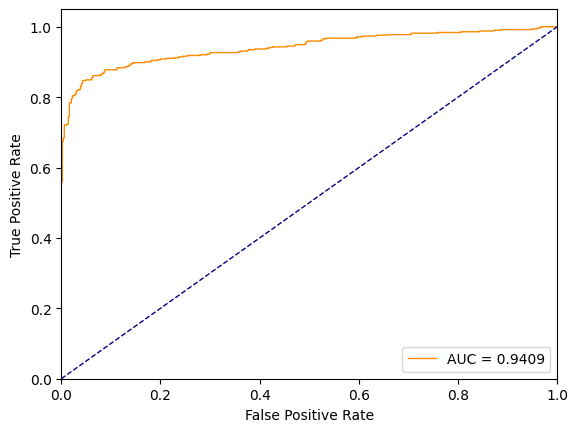

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.35
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


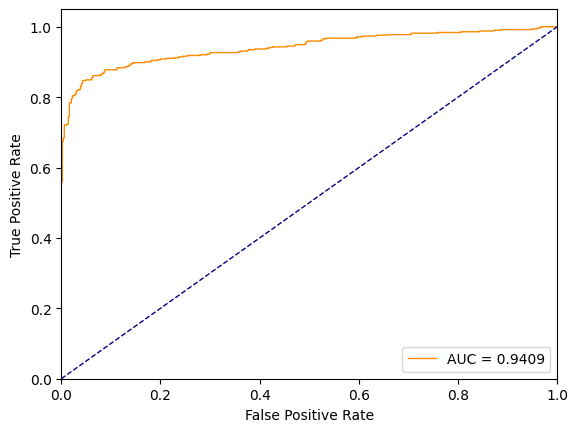

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.4
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


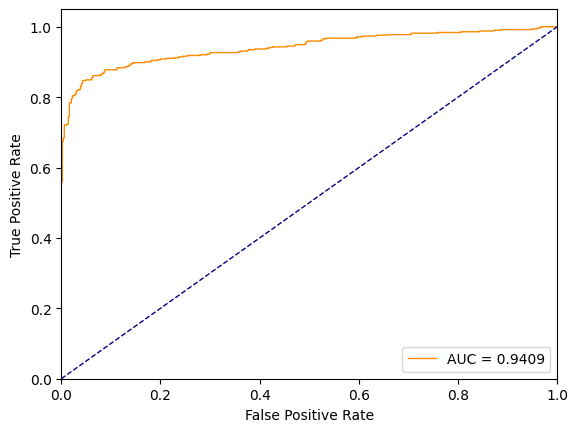

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.45
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


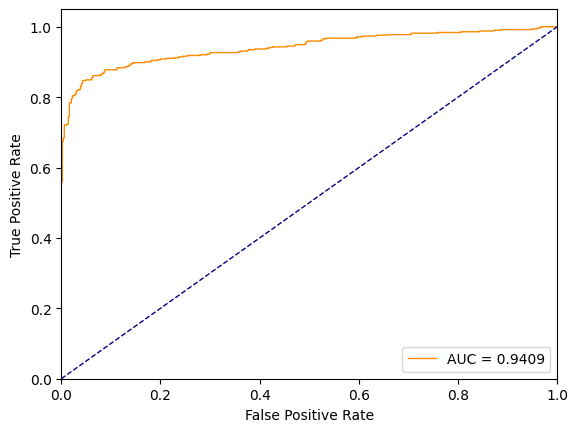

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.5
TP: 490.0
FP: 477.0
TN: 13.0
FN: 0.0


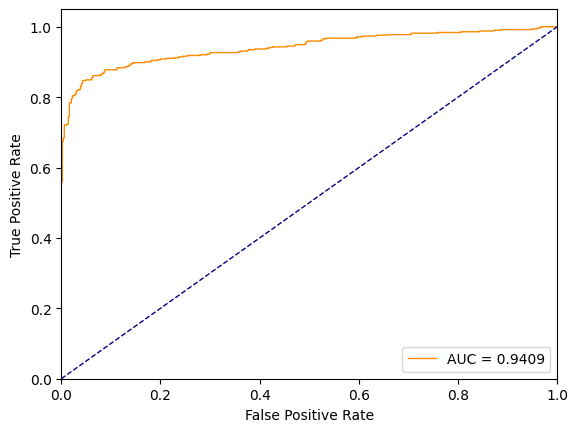

accuracy: 0.5133, recall: 1.0, precision: 0.5067, F1_score: 0.6726, MCC: 0.1159
threshold: 0.55
TP: 470.0
FP: 246.0
TN: 244.0
FN: 20.0


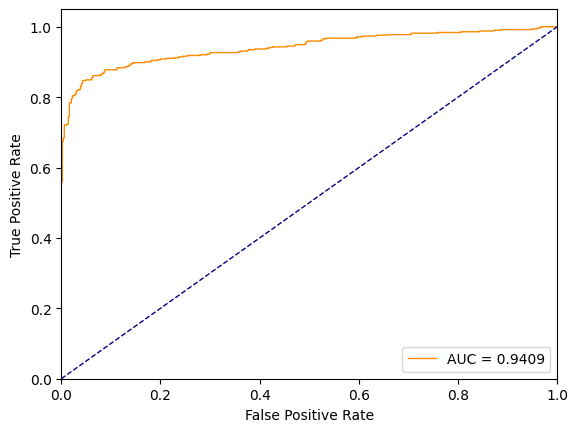

accuracy: 0.7286, recall: 0.9592, precision: 0.6564, F1_score: 0.7794, MCC: 0.5152
threshold: 0.6
TP: 454.0
FP: 152.0
TN: 338.0
FN: 36.0


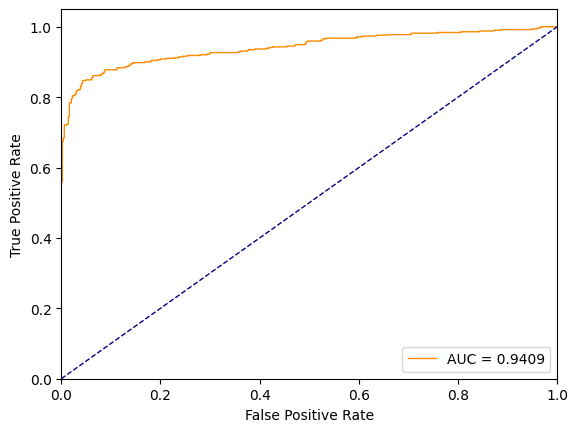

accuracy: 0.8082, recall: 0.9265, precision: 0.7492, F1_score: 0.8285, MCC: 0.6344
threshold: 0.65
TP: 441.0
FP: 82.0
TN: 408.0
FN: 49.0


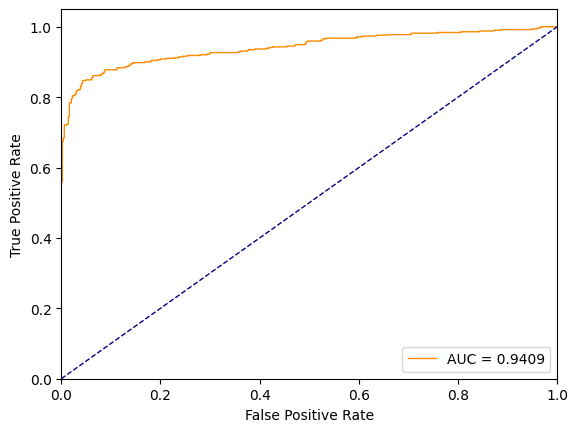

accuracy: 0.8663, recall: 0.9, precision: 0.8432, F1_score: 0.8707, MCC: 0.7343
threshold: 0.7
TP: 430.0
FP: 49.0
TN: 441.0
FN: 60.0


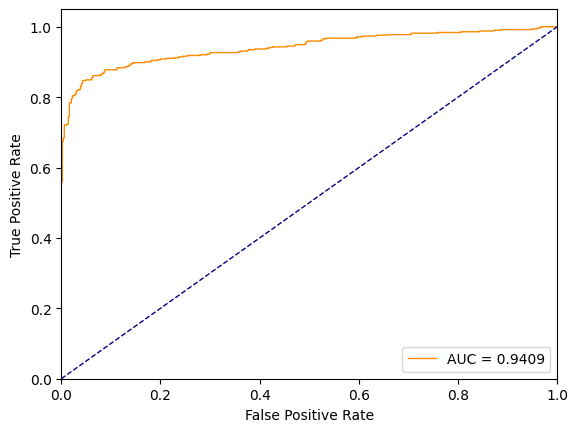

accuracy: 0.8888, recall: 0.8776, precision: 0.8977, F1_score: 0.8875, MCC: 0.7777
threshold: 0.75
TP: 421.0
FP: 31.0
TN: 459.0
FN: 69.0


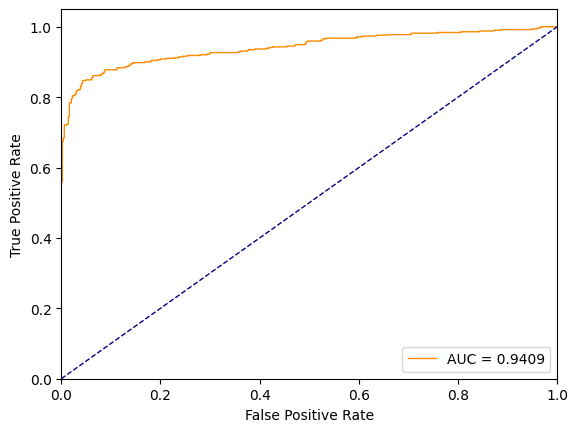

accuracy: 0.898, recall: 0.8592, precision: 0.9314, F1_score: 0.8938, MCC: 0.7983
threshold: 0.8
TP: 409.0
FP: 20.0
TN: 470.0
FN: 81.0


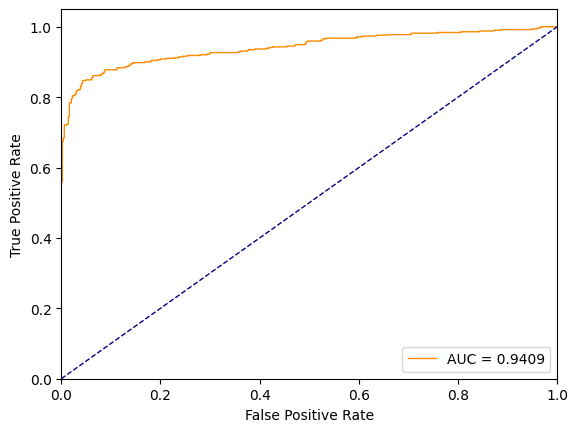

accuracy: 0.8969, recall: 0.8347, precision: 0.9534, F1_score: 0.8901, MCC: 0.8001
threshold: 0.85
TP: 395.0
FP: 13.0
TN: 477.0
FN: 95.0


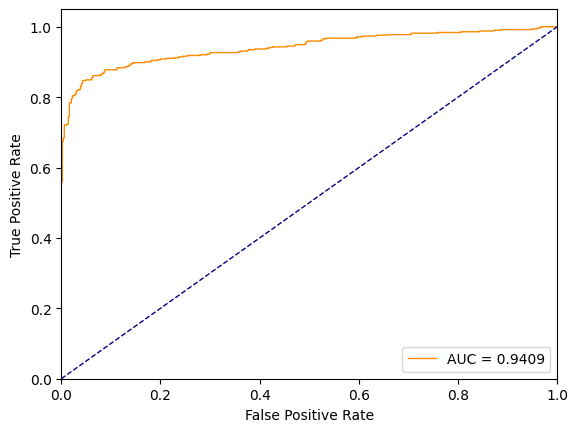

accuracy: 0.8898, recall: 0.8061, precision: 0.9681, F1_score: 0.8797, MCC: 0.7907
threshold: 0.9
TP: 369.0
FP: 8.0
TN: 482.0
FN: 121.0


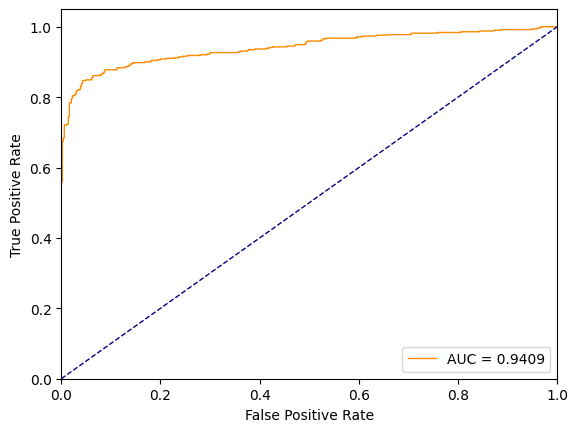

accuracy: 0.8684, recall: 0.7531, precision: 0.9788, F1_score: 0.8512, MCC: 0.7571
threshold: 0.95
TP: 338.0
FP: 3.0
TN: 487.0
FN: 152.0


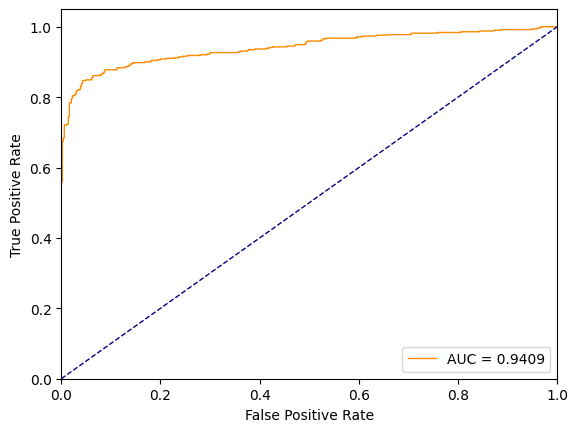

accuracy: 0.8418, recall: 0.6898, precision: 0.9912, F1_score: 0.8135, MCC: 0.7177


In [21]:
# Setting the generator and discriminator to evaluation mode
generator.eval()
discriminator.eval()

accuracies, recalls, precisions, F1_scores, MCCs = [], [], [], [], []
thresholds_list = []

print('start running on test mode...')
for i in range(1, 20):
    # Initializing confusion matrix elements
    TP = 0  # True Positives
    FP = 0  # False Positives
    TN = 0  # True Negatives
    FN = 0  # False Negatives
    all_pred = []  # List to store all predictions
    all_labels = []  # List to store all labels
    threshold = i / 20  # Setting threshold for fraud detection
    print('threshold:', threshold)

    # Iterating over the test dataset
    for i, (features, labels) in enumerate(testDataLoader):
        # Test Discriminator
        # Reconstructing the features using the generator
        reconstructed_features = generator(features)
        # Getting probability of fraud from the discriminator
        p_fraud = discriminator(reconstructed_features)
        p_fraud = sig(p_fraud)  # Applying sigmoid activation
        p_fraud = p_fraud.squeeze()
        # Converting predictions to list and appending to all_pred
        all_pred.extend(p_fraud.tolist())
        # Appending labels to all_labels
        all_labels.extend(labels.tolist())

        # Determining final prediction based on threshold
        final_pred = torch.zeros(p_fraud.size())
        final_pred[p_fraud >= threshold] = 1

        # Updating confusion matrix elements
        TP += torch.sum((final_pred == 1) & (labels == 1))
        FP += torch.sum((final_pred == 1) & (labels == 0))
        TN += torch.sum((final_pred == 0) & (labels == 0))
        FN += torch.sum((final_pred == 0) & (labels == 1))

    # Display confusion matrix elements
    print('TP:', float(TP))
    print('FP:', float(FP))
    print('TN:', float(TN))
    print('FN:', float(FN))

    # Calculating and plotting ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plot_and_save_fig(fpr, tpr, roc_auc)

    # Calculating performance metrics
    accuracy = get_accuracy(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    recall = get_recall(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    precision = get_precision(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    F1_score = get_F1_score(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    MCC = get_MCC(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    F1_scores.append(F1_score)
    MCCs.append(MCC)
    thresholds_list.append(threshold)

    # Displaying the calculated metrics
    print("accuracy: {}, recall: {}, precision: {}, F1_score: {}, MCC: {}".format(accuracy, recall, precision, F1_score, MCC))


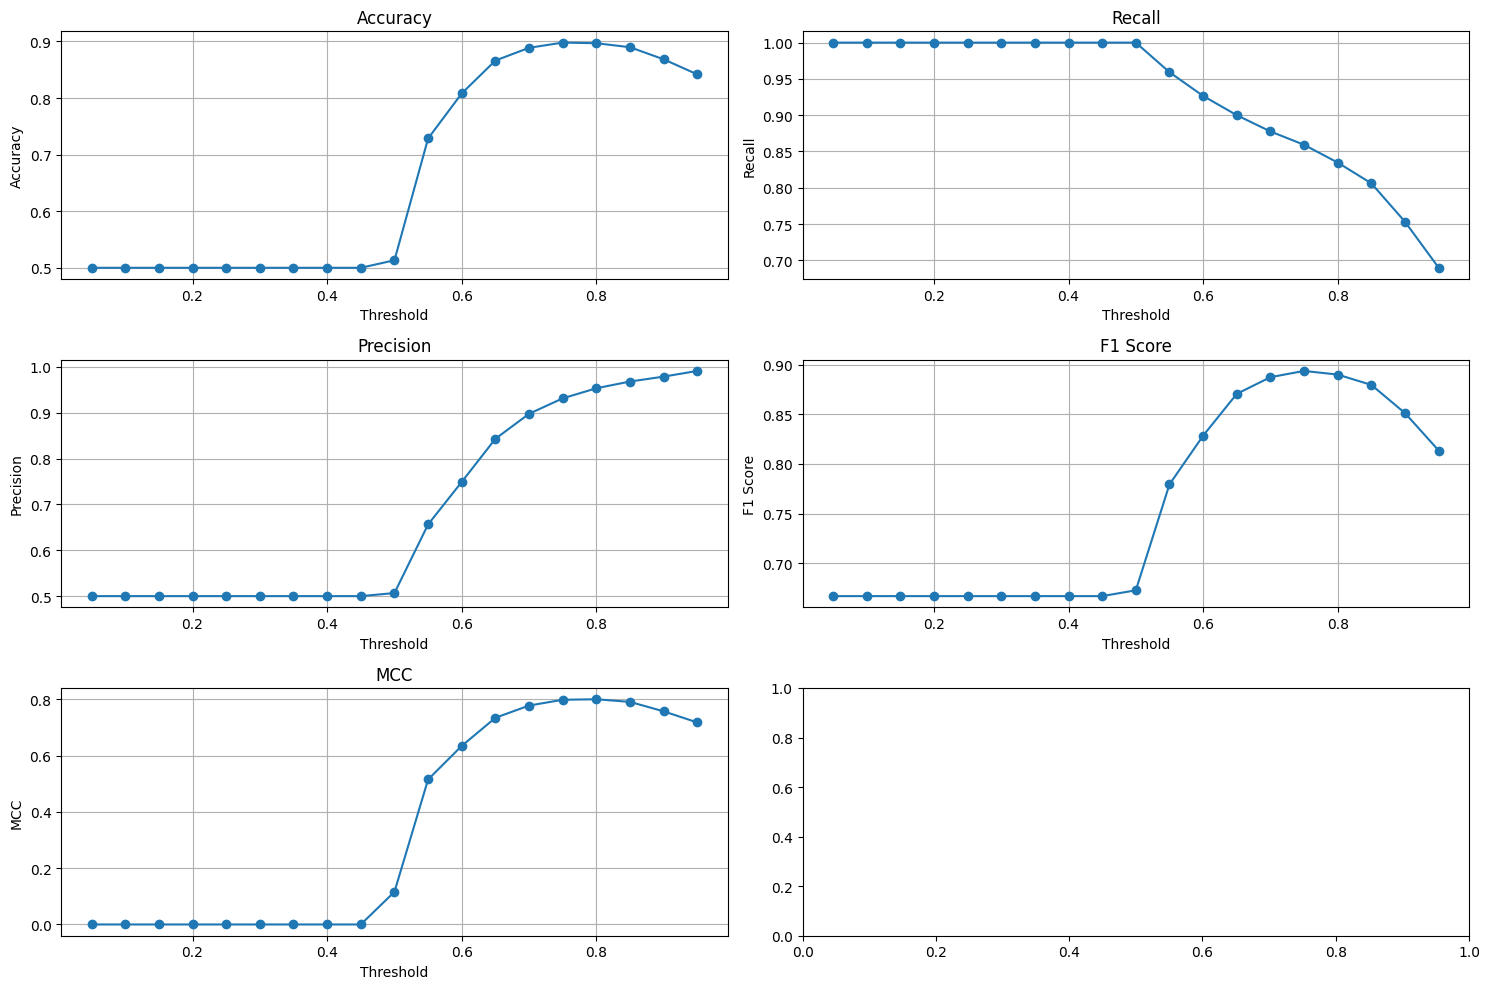

In [23]:
def add_metric_subplot(ax, metric_values, metric_name, thresholds_list):
    ax.plot(thresholds_list, metric_values, marker='o')
    ax.set_title(f'{metric_name}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel(metric_name)
    ax.grid(True)

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns

# Adding each metric to the subplots
add_metric_subplot(axs[0, 0], accuracies, "Accuracy", thresholds_list)
add_metric_subplot(axs[0, 1], recalls, "Recall", thresholds_list)
add_metric_subplot(axs[1, 0], precisions, "Precision", thresholds_list)
add_metric_subplot(axs[1, 1], F1_scores, "F1 Score", thresholds_list)
add_metric_subplot(axs[2, 0], MCCs, "MCC", thresholds_list)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

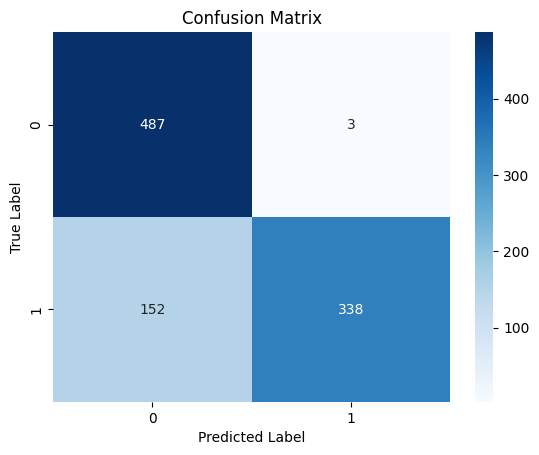

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


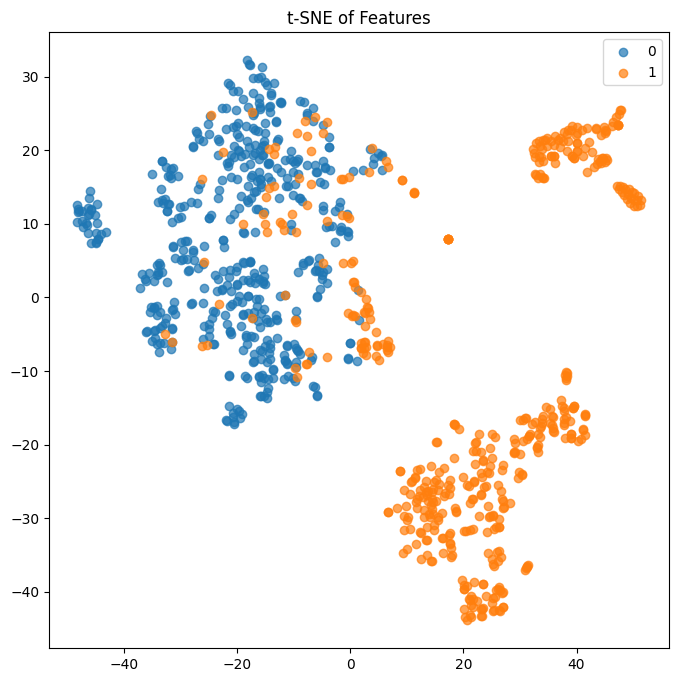

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features[:1000])

plt.figure(figsize=(8, 8))
for cl in [0, 1]:  # Assuming binary classes: 0 and 1
    indices = labels[:1000] == cl
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=cl, alpha=0.7)
plt.legend()
plt.title('t-SNE of Features')
plt.show()
